In [5]:
import pandas as pd
import cv2
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from torch import nn, optim
import time
from tempfile import TemporaryDirectory
import os

device = torch.device('cuda:0')

In [9]:
rows = pd.read_csv('content/outFrames/content.csv')
rows['class'] = rows['class'].fillna('None')

In [10]:
rows.groupby(['class']).count()

,frame_name,video_name,interval,frame_number,type,path
class,,,,,,
None,1517,1517,1517,1517,1517,1517
UD,1435,1435,1435,1435,1435,1435
WF,1517,1517,1517,1517,1517,1517


In [12]:
frames = { 'Train': [], 'Test': [] }
class_idxs =  { 'UD': 0, 'WF': 1, 'None': 2 } 
class_names = [ 'UD', 'WF', 'None' ]
main_ndarray = np.load('content/frame_array.npy')
main_ndarray = main_ndarray.astype('float32')

# BGR->RGB
main_ndarray = np.stack([
    main_ndarray[:, :, :, 2],
    main_ndarray[:, :, :, 1],
    main_ndarray[:, :, :, 0],
], axis=-1)
# (H,W,C) -> (C,W,H)
main_ndarray = main_ndarray.transpose((0, 3, 1, 2))
# Normalize
main_ndarray = (main_ndarray - 128.0) / 128.0 

grouped = rows.groupby(['video_name', 'interval', 'class', 'type'], as_index=False)
count = 0
for grp, values in grouped:
    if len(values) < 16:
        continue

    # TODO: Can get more sample if values is larger than 16 frame
    idxs = []
    for idx, row in values.iterrows():
        idxs.append(idx)
        if len(idxs) == 16:
            frame_ndarray = main_ndarray[idxs,]
            frames[grp[3]].append((frame_ndarray, class_idxs[grp[2]]))
            idxs = []

In [13]:
dataloaders = {
    'Train': torch.utils.data.DataLoader(frames['Train'], batch_size=4, shuffle=True, num_workers=4),
    'Test': torch.utils.data.DataLoader(frames['Test'], batch_size=4, shuffle=True, num_workers=4),
}

dataset_sizes = {
    'Train': len(frames['Train']),
    'Test': len(frames['Test']), 
}

print(f'Size of training set {dataset_sizes["Train"]}')
print(f'Size of testing set {dataset_sizes["Test"]}')

Size of training set 196
Size of testing set 56


In [14]:
label_count = {}
for _, k in frames["Train"]:
    if class_names[k] not in label_count:
        label_count[class_names[k]] = 0
    label_count[class_names[k]] += 1

label_count

{'None': 70, 'UD': 64, 'WF': 62}

In [15]:
label_count = {}
for _, k in frames["Test"]:
    if class_names[k] not in label_count:
        label_count[class_names[k]] = 0
    label_count[class_names[k]] += 1

label_count

{'None': 15, 'WF': 23, 'UD': 18}

In [16]:

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


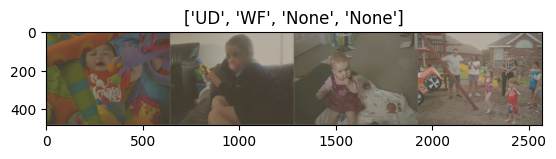

In [17]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))
inputs = inputs[:,0]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

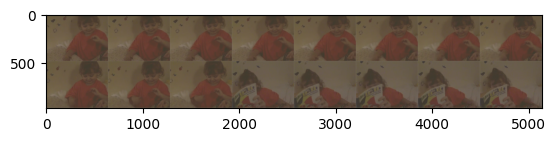

In [18]:
# Get a frame
inputs, classes = next(iter(dataloaders['Train']))
inputs = inputs[0,:]

# Make a grid from frame
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [25]:
def train_model(model, criterion, optimizer, scheduler, transform=None, num_epochs=25):
    since = time.time()
    losses = {'Train': [], 'Test': []}
    accuracies = {'Train': [], 'Test': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = './best_model_params.pt'

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['Train', 'Test']:
                if phase == 'Train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    if transform != None:
                        inputs = transform(inputs).to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'Train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                losses[phase].append(float(epoch_loss))
                accuracies[phase].append(float(epoch_acc))

                # deep copy the model
                if phase == 'Test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            # Stop early on two consecutive higher test loss
            #if len(losses['Test']) > 2 and losses['Test'][-1] > losses['Test'][-2] and losses['Test'][-2] > losses['Test'][-3]:
                #break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    _, axes = plt.subplots(2, 1)
    axes[0].plot(losses['Train'], label='Train loss')
    axes[0].plot(losses['Test'], label='Test loss')
    axes[0].legend()
    
    axes[1].plot(accuracies['Train'], label='Train accuracy')
    axes[1].plot(accuracies['Test'], label='Test accuracy')
    axes[1].legend()
    
    return model

In [26]:
model_ft = torchvision.models.video.mvit_v2_s(weights=torchvision.models.video.MViT_V2_S_Weights.KINETICS400_V1)
model_ft.head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(768, len(class_names)),
)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/9
----------
Train Loss: 0.8797 Acc: 0.6939
Test Loss: 0.8659 Acc: 0.6429
Epoch 1/9
----------
Train Loss: 0.6770 Acc: 0.7551
Test Loss: 0.8339 Acc: 0.6607
Epoch 2/9
----------
Train Loss: 0.5122 Acc: 0.8265
Test Loss: 0.7902 Acc: 0.6786
Epoch 3/9
----------
Train Loss: 0.4642 Acc: 0.8214
Test Loss: 0.8227 Acc: 0.6786
Epoch 4/9
----------
Train Loss: 0.3934 Acc: 0.8571
Test Loss: 0.8190 Acc: 0.6607
Epoch 5/9
----------
Train Loss: 0.3474 Acc: 0.8724
Test Loss: 0.8384 Acc: 0.6786
Epoch 6/9
----------
Train Loss: 0.3037 Acc: 0.8776
Test Loss: 0.8680 Acc: 0.6786
Epoch 7/9
----------
Train Loss: 0.2428 Acc: 0.9337
Test Loss: 0.8612 Acc: 0.6964
Epoch 8/9
----------
Train Loss: 0.2207 Acc: 0.9490
Test Loss: 0.8414 Acc: 0.6786
Epoch 9/9
----------
Train Loss: 0.2163 Acc: 0.9592
Test Loss: 0.8425 Acc: 0.6786
Training complete in 3m 10s
Best val Acc: 0.696429


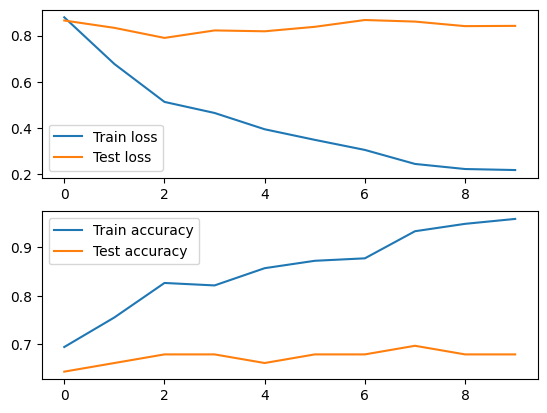

In [28]:
model_transform = torchvision.models.video.MViT_V2_S_Weights.KINETICS400_V1.transforms()
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, transform=model_transform,
                       num_epochs=10)

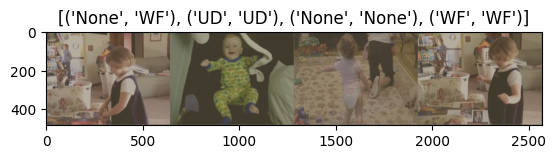

In [29]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Test']))

inferred_class = model_ft(model_transform(inputs.to(device)))

predicted_class = list(torch.argmax(inferred_class, dim=-1))
inputs = inputs[:,0]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[(class_names[classes[x]], class_names[predicted_class[x]]) for x in range(len(classes))])